In [5]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import pickle
from time import time
import matplotlib.pyplot as plt
from ast import literal_eval
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from video_loader import *
from utils import *

import warnings
warnings.simplefilter('ignore', category=np.ComplexWarning)
warnings.simplefilter('ignore', category=pd.core.common.SettingWithCopyWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
metadata_filenames = ['DET0101_V1_HI_Front_SJR.csv', 'DET0101_V2_HI_Front_SJR.csv', 'DET0101_V4_HI_Laptop_SJR.csv']
nlines_skip = 15
meta_dfs = [pd.read_csv('data/'+filename, skiprows=nlines_skip).dropna(axis=1, how='all') for filename in metadata_filenames]
for metadata in meta_dfs:
    assert len(metadata['Media file path'].unique()) == 1
    assert len(metadata['FPS'].unique()) == 1
    assert len(metadata['Total length'].unique()) == 1
    metadata.columns = [c if c != 'Tic Number' else 'Behavioral category' for c in metadata.columns]

for i in range(len(meta_dfs)):
    display(meta_dfs[i])

,Time,Media file path,Total length,FPS,AtypicalActivity,Behavior,Behavioral category,Movement Type,Status,Eye squeeze,3
0,13.747,C:/Users/sara1/Downloads/DET0101_V1_HI_Front.MOV,957.23,29.97,1,Eye squeeze,3,2,START,Eyebrow raise,4.0
1,14.147,C:/Users/sara1/Downloads/DET0101_V1_HI_Front.MOV,957.23,29.97,1,Eye squeeze,3,2,STOP,Eyebrow in/down,5.0
2,16.183,C:/Users/sara1/Downloads/DET0101_V1_HI_Front.MOV,957.23,29.97,1,Pursing lips,11,2,START,Nose scrunch up,6.0
3,17.851,C:/Users/sara1/Downloads/DET0101_V1_HI_Front.MOV,957.23,29.97,1,Eye squeeze,3,2,START,Nostril flare/Nose down,7.0
4,18.452,C:/Users/sara1/Downloads/DET0101_V1_HI_Front.MOV,957.23,29.97,1,Eye squeeze,3,2,STOP,Teeth grinding,8.0
...,...,...,...,...,...,...,...,...,...,...,...
351,925.192,C:/Users/sara1/Downloads/DET0101_V1_HI_Front.MOV,957.23,29.97,1,Nostril flare/Nose down,7,2,STOP,NaN,NaN
352,926.460,C:/Users/sara1/Downloads/DET0101_V1_HI_Front.MOV,957.23,29.97,9999,bad segment,9999,2,START,NaN,NaN
353,927.294,C:/Users/sara1/Downloads/DET0101_V1_HI_Front.MOV,957.23,29.97,9999,bad segment,9999,2,STOP,NaN,NaN
354,933.634,C:/Users/sara1/Downloads/DET0101_V1_HI_Front.MOV,957.23,29.97,1,Eye squeeze,3,2,START,NaN,NaN


,Time,Media file path,Total length,FPS,AtypicalActivity,Behavior,Behavioral category,Movement Type,Status,Nose scrunch up,6
0,3.904,C:/Users/sara1/Downloads/DET0101_V2_HI_Front.MOV,954.97,29.97,1,Non-tic atypical movement,1,1,START,Nostril flare/Nose down,7.0
1,9.009,C:/Users/sara1/Downloads/DET0101_V2_HI_Front.MOV,954.97,29.97,1,Non-tic atypical movement,1,1,STOP,Teeth grinding,8.0
2,30.464,C:/Users/sara1/Downloads/DET0101_V2_HI_Front.MOV,954.97,29.97,9999,bad segment,9999,2,START,Ab tensing,9.0
3,31.331,C:/Users/sara1/Downloads/DET0101_V2_HI_Front.MOV,954.97,29.97,9999,bad segment,9999,2,STOP,Tongue on roof of mouth,10.0
4,35.435,C:/Users/sara1/Downloads/DET0101_V2_HI_Front.MOV,954.97,29.97,1,Eye squeeze,3,2,START,Pursing lips,11.0
...,...,...,...,...,...,...,...,...,...,...,...
515,935.602,C:/Users/sara1/Downloads/DET0101_V2_HI_Front.MOV,954.97,29.97,1,Nostril flare/Nose down,7,2,STOP,NaN,NaN
516,937.271,C:/Users/sara1/Downloads/DET0101_V2_HI_Front.MOV,954.97,29.97,1,Eye squeeze,3,2,START,NaN,NaN
517,938.405,C:/Users/sara1/Downloads/DET0101_V2_HI_Front.MOV,954.97,29.97,1,Eye squeeze,3,2,STOP,NaN,NaN
518,941.041,C:/Users/sara1/Downloads/DET0101_V2_HI_Front.MOV,954.97,29.97,1,Pursing lips,11,2,START,NaN,NaN


,Time,Media file path,Total length,FPS,AtypicalActivity,Behavior,Behavioral category,Movement Type,Status,Eye squeeze,3
0,8.238,C:/Users/sara1/Downloads/DET0101_V4_HI_Laptop.mp4,974.66,30.47,1,Pursing lips,11,2,START,Eyebrow raise,4.0
1,10.535,C:/Users/sara1/Downloads/DET0101_V4_HI_Laptop.mp4,974.66,30.47,1,Pursing lips,11,2,STOP,Eyebrow in/down,5.0
2,59.797,C:/Users/sara1/Downloads/DET0101_V4_HI_Laptop.mp4,974.66,30.47,9999,bad segment,9999,2,START,Nose scrunch up,6.0
3,60.387,C:/Users/sara1/Downloads/DET0101_V4_HI_Laptop.mp4,974.66,30.47,9999,bad segment,9999,2,STOP,Nostril flare/Nose down,7.0
4,71.546,C:/Users/sara1/Downloads/DET0101_V4_HI_Laptop.mp4,974.66,30.47,9999,bad segment,9999,2,START,Teeth grinding,8.0
...,...,...,...,...,...,...,...,...,...,...,...
73,905.743,C:/Users/sara1/Downloads/DET0101_V4_HI_Laptop.mp4,974.66,30.47,1,Nostril flare/Nose down,7,2,STOP,NaN,NaN
74,921.792,C:/Users/sara1/Downloads/DET0101_V4_HI_Laptop.mp4,974.66,30.47,9999,bad segment,9999,2,START,NaN,NaN
75,923.105,C:/Users/sara1/Downloads/DET0101_V4_HI_Laptop.mp4,974.66,30.47,9999,bad segment,9999,2,STOP,NaN,NaN
76,923.203,C:/Users/sara1/Downloads/DET0101_V4_HI_Laptop.mp4,974.66,30.47,9999,bad segment,9999,2,START,NaN,NaN


#### Process metadata:

Find start and stop timestamps for normal and tic fragments

In [7]:
videos_args = {'torch': False,
           'gray': True,
           'sample_shape': (512**2,)}
ncomp = 10

In [4]:
videos_data = []

for metadata in meta_dfs:
    filename = 'data/'+metadata['Media file path'].str.extract('/([^/]+)$').values[0][0]
    print(filename)

    fps = metadata['FPS'].values[0]
    print(fps, cv2.VideoCapture(filename).get(cv2.CAP_PROP_FPS))

    fragments = []
    first = metadata.iloc[0,:]
    others = metadata.iloc[1:,:]
    behavior_change = first['Time']
    stack = [first['Behavioral category']]
    discard = False
    for _, line in others.iterrows():
        if line['AtypicalActivity'] == 9999:
            discard = True

        if line['Status'] == 'START':
            if stack == []:
                fragments.append((behavior_change, line['Time'], 0))
                behavior_change = line['Time']

            stack.append(line['Behavioral category'])
        elif line['Status'] == 'STOP':
            stack.reverse()
            stack.remove(line['Behavioral category'])
            stack.reverse()

            if stack == []:
                if not discard:
                    fragments.append((behavior_change, line['Time'], 1))
                else:
                    discard = False
                behavior_change = line['Time']

    fragments = np.array(fragments)
    fragments_f = np.hstack((fragments[:,:2]*fps, fragments[:,-1:])).astype(int)
    start_frame = fragments_f[0][0]
    end_frame = fragments_f[-1,1]
    fragments_f[:,:2] = fragments_f[:,:2] - start_frame
    nframes = end_frame-start_frame+1
    mask_for_tics = np.full(nframes, False)
    for a, b, c in fragments_f:
        if c == 0:
            mask_for_tics[a:b] = True
    tic_mask = np.ma.masked_array([0]*nframes, mask_for_tics)

    # Extract discarded fragments
    metadata_discard = metadata.loc[metadata['Behavioral category']==9999, :]
    metadata_discard['next time'] = metadata['Time'].shift(periods=-1).iloc[::2]
    bad_fragments = metadata_discard[['Time', 'next time']].values[:-1]
    bad_fragments_f = (bad_fragments*fps).astype(int)
    bad_fragments_f[np.all(bad_fragments >= start_frame, axis=1)]
    bad_fragments_f[np.all(bad_fragments <= end_frame, axis=1)]
    bad_fragments_f = bad_fragments_f - start_frame
    mask_for_bad = np.full(nframes, True)
    for a, b in bad_fragments_f:
        mask_for_bad[a:b] = False
    bad_mask = np.ma.masked_array([0]*nframes, mask_for_bad)

    videos_data.append({'filename': filename,
                        'fps': fps,
                        'nframes': nframes,
                        'fragments': fragments,
                        'start frame': start_frame,
                        'fragments by frame':fragments_f,
                        'tic_mask': tic_mask})

data/DET0101_V1_HI_Front.MOV
29.97 29.97002997002997
data/DET0101_V2_HI_Front.MOV
29.97 29.97002997002997
data/DET0101_V4_HI_Laptop.mp4
30.47 30.0


In [9]:
for i, metadata in enumerate(meta_dfs):
   # Extract discarded fragments
    start_frame = videos_data[i]['start frame']
    nframes = videos_data[i]['nframes']
    end_frame = start_frame + nframes - 1
    metadata_discard = metadata.loc[metadata['Behavioral category']==9999, :].iloc[::2]
    metadata_discard['next time'] = metadata['Time'].shift(periods=-1)
    bad_fragments = metadata_discard[['Time', 'next time']].values[:-1]
    bad_fragments_f = (bad_fragments*fps).astype(int)
    bad_fragments_f[np.all(bad_fragments >= start_frame, axis=1)]
    bad_fragments_f[np.all(bad_fragments <= end_frame, axis=1)]
    bad_fragments_f = bad_fragments_f - start_frame
    mask_for_bad = np.full(nframes, True)
    for a, b in bad_fragments_f:
        mask_for_bad[a:b] = False
    bad_mask = np.ma.masked_array([0]*nframes, mask_for_bad)
    videos_data[i].update({'bad_mask': bad_mask})

#### Define the videos

In [7]:
for video_data in videos_data:
    filename = video_data['filename']
    fps = video_data['fps']

    fragments_f = video_data['fragments by frame']

    normal_intervals_f = fragments_f[fragments_f[:,2]==0][:,:2]
    video_data['normal_fragments'] = [VideoLoader(filename, start_frame=a, duration_frames=b-a+1, **videos_args) for a, b in normal_intervals_f]
    video_data['video'] = VideoLoader(filename, start_frame=start_frame, duration_frames=nframes, **videos_args)

#### Fit pca to frames without tic

In [8]:
for video_data in videos_data:
    fragments = video_data['normal_fragments']
    normal_frames = []
    for fragment in fragments:
        fragment.skip_frame = 3
        normal_frames.append(fragment.get_all_frames(allow_skip=True))
        fragment.skip_frame = 0
    normal_frames = np.vstack(normal_frames)
    normal_pca = custom_pca(ncomp)
    normal_pca.fit(normal_frames)
    video_data['normal_pca'] = normal_pca

#### Encode the video and compute transition matrix for all frames

In [9]:
for video_data in videos_data:
    normal_frames_enc = []
    for fragment in video_data['normal_fragments']:
        for frames in fragment:
            normal_frames_enc.append(video_data['normal_pca'].encode(frames)[0])
    normal_frames_enc = np.vstack(normal_frames_enc)

    video_data['A_normal'] = np.linalg.pinv(normal_frames_enc[:-1])@normal_frames_enc[1:]

In [12]:
videos_data_save = [{k: v for k, v in video_data.items() if k != 'video' and k != 'normal_fragments' and k != 'tic_fragments'} for video_data in videos_data]
pickle.dump(videos_data_save, open('data_generated/videos_data_tic_detection.pkl', 'wb'))

#### Reconstruct all frames and compute the reconstruction error

In [4]:
videos_data = pickle.load(open('data_generated/videos_data_tic_detection.pkl', 'rb'))
for i, video_data in enumerate(videos_data):
    filename = video_data['filename']
    fps = video_data['fps']
    video_data['video'] = VideoLoader(filename, start_frame=video_data['start frame'], duration_frames=video_data['nframes'], **videos_args)

In [12]:
start = time()
for video_data in videos_data:
    video = video_data['video']
    print('Video: ', video_data['filename'], f'(started {sec2string(time()-start)} time ago)')
    all_frames_rec = []
    for i, frames in enumerate(video):
        if i % 140 == 0:
            print(f'Encoded {sec2string(float(i*video.batch_size)/video.fps)} of the video (started {sec2string(time()-start)} time ago)')
        frames_enc = video_data['normal_pca'].encode(frames)[0]
        all_frames_rec.append(video_data['normal_pca'].decode(frames_enc @ video_data['A_normal']))
    print(f'All frame\'s reconstruction computed (started {sec2string(time()-start)} time ago)')
    all_frames_rec = np.vstack(all_frames_rec)[:-1]
    errors = np.zeros(all_frames_rec.shape[0])

    video.start_frame = 1
    video.duration_frames -= 1
    for i, frames in enumerate(video):
        frames_rec = all_frames_rec[i*video.batch_size:(i+1)*video.batch_size]
        errors[i*video.batch_size:(i+1)*video.batch_size] = np.mean((frames-frames_rec)**2, axis=1)
    video.start_frame = 0
    video.duration_frames += 1

    video_data['errors_normal_models'] = errors
    videos_data_save = [{k: v for k, v in video_data.items() if k != 'video' and k != 'normal_fragments' and k != 'tic_fragments'} for video_data in videos_data]
    print()

Video:  data/DET0101_V1_HI_Front.MOV (started 0.0 time ago)
Encoded 0.0 of the video (started 1.78 time ago)
Encoded 0:04:59 of the video (started 0:09:07 time ago)
Encoded 0:09:57 of the video (started 0:17:22 time ago)
Encoded 0:14:56 of the video (started 0:25:47 time ago)
All frame's reconstruction computed (started 0:26:19 time ago)

Video:  data/DET0101_V2_HI_Front.MOV (started 0:50:25 time ago)
Encoded 0.0 of the video (started 0:50:30 time ago)
Encoded 0:04:59 of the video (started 0:59:56 time ago)
Encoded 0:09:57 of the video (started 1:09:19 time ago)
Encoded 0:14:56 of the video (started 1:17:34 time ago)
All frame's reconstruction computed (started 1:18:38 time ago)

Video:  data/DET0101_V4_HI_Laptop.mp4 (started 1:43:25 time ago)
Encoded 0.0 of the video (started 1:43:28 time ago)
Encoded 0:04:59 of the video (started 1:51:38 time ago)
Encoded 0:09:57 of the video (started 2:00:03 time ago)
Encoded 0:14:56 of the video (started 2:07:56 time ago)
All frame's reconstruction

In [36]:
#videos_data_save = [{k: v for k, v in video_data.items() if k != 'video' and k != 'normal_fragments' and k != 'tic_fragments'} for video_data in videos_data]
#pickle.dump(videos_data_save, open('data_generated/videos_data_tic_detection.pkl', 'wb'))

#### Plot the distribution of reconstruction error with and without tics to see if there is a relation

In [17]:
videos_data = pickle.load(open('data_generated/videos_data_tic_detection.pkl', 'rb'))
for i, video_data in enumerate(videos_data):
    filename = video_data['filename']
    fps = video_data['fps']
    video_data['video'] = VideoLoader(filename, start_frame=video_data['start frame'], duration_frames=video_data['nframes'], **videos_args)

Tic: 58.28210521939355 33.33091926574707
Normal: 61.73854280305204 32.686357498168945
Tic: 197.89140781573394 57.12113380432129
Normal: 156.9624749818356 58.802452087402344
Tic: 258.61089918763054 91.56010437011719
Normal: 186.09954031464827 69.85337829589844


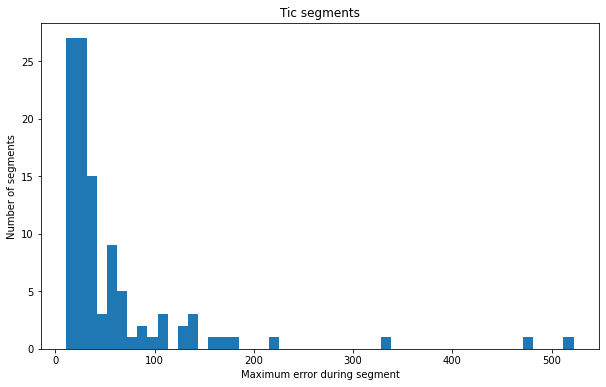

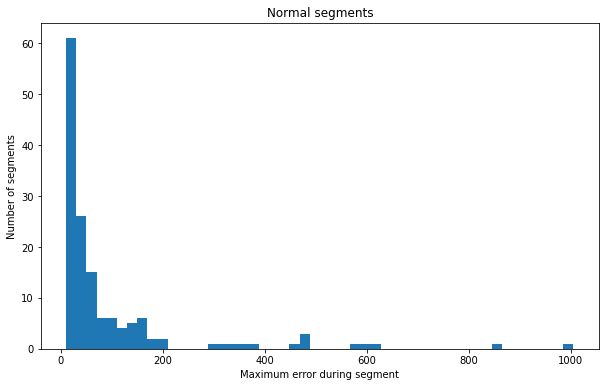

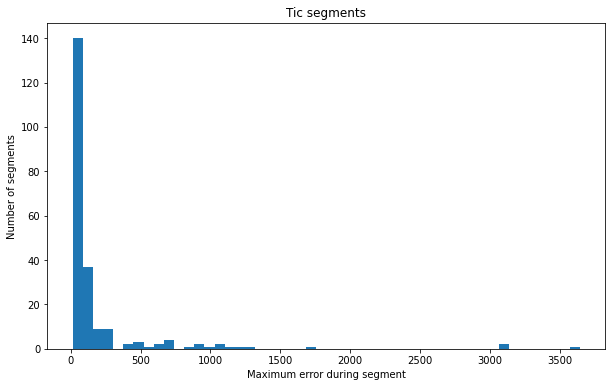

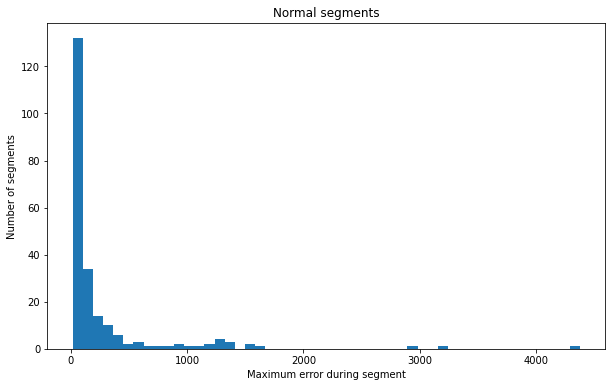

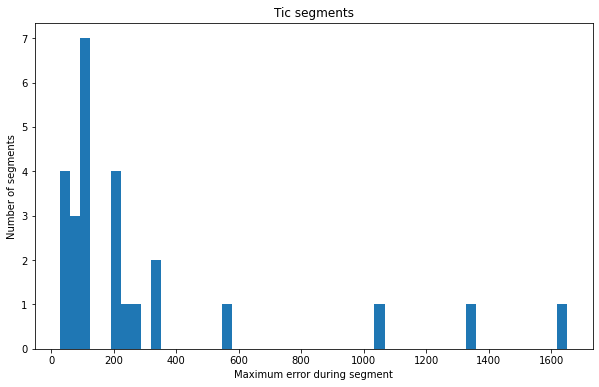

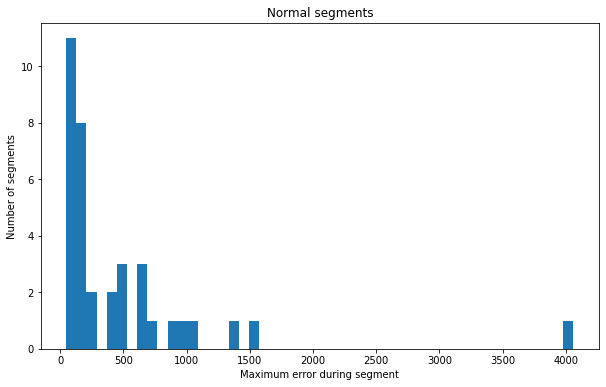

In [5]:
for video_data in videos_data:
    fragments_f = video_data['fragments by frame']

    normal_intervals_f = fragments_f[fragments_f[:,2]==0][:,:2]
    tic_intervals_f = fragments_f[fragments_f[:,2]!=0][:,:2]
    tic_errors = [video_data['errors_normal_models'][a:b] for a, b in tic_intervals_f]
    normal_errors = [video_data['errors_normal_models'][a:b] for a, b in normal_intervals_f]

    print('Tic:', np.mean(np.hstack(tic_errors)), np.median(np.hstack(tic_errors)))
    plt.figure(figsize=(10,6))
    plt.title('Tic segments')
    plt.xlabel('Maximum error during segment')
    plt.ylabel('Number of segments')
    plt.hist([np.max(x) for x in tic_errors if len(x) > 0], bins=50)
    plt.show
    print('Normal:', np.mean(np.hstack(normal_errors)), np.median(np.hstack(normal_errors)))
    plt.figure(figsize=(10,6))
    plt.title('Normal segments')
    plt.xlabel('Maximum error during segment')
    plt.ylabel('Number of segments')
    plt.hist([np.max(x) for x in normal_errors if len(x) > 0], bins=50)
    plt.show

#### Plot the reconstruction error along with the tic occurences

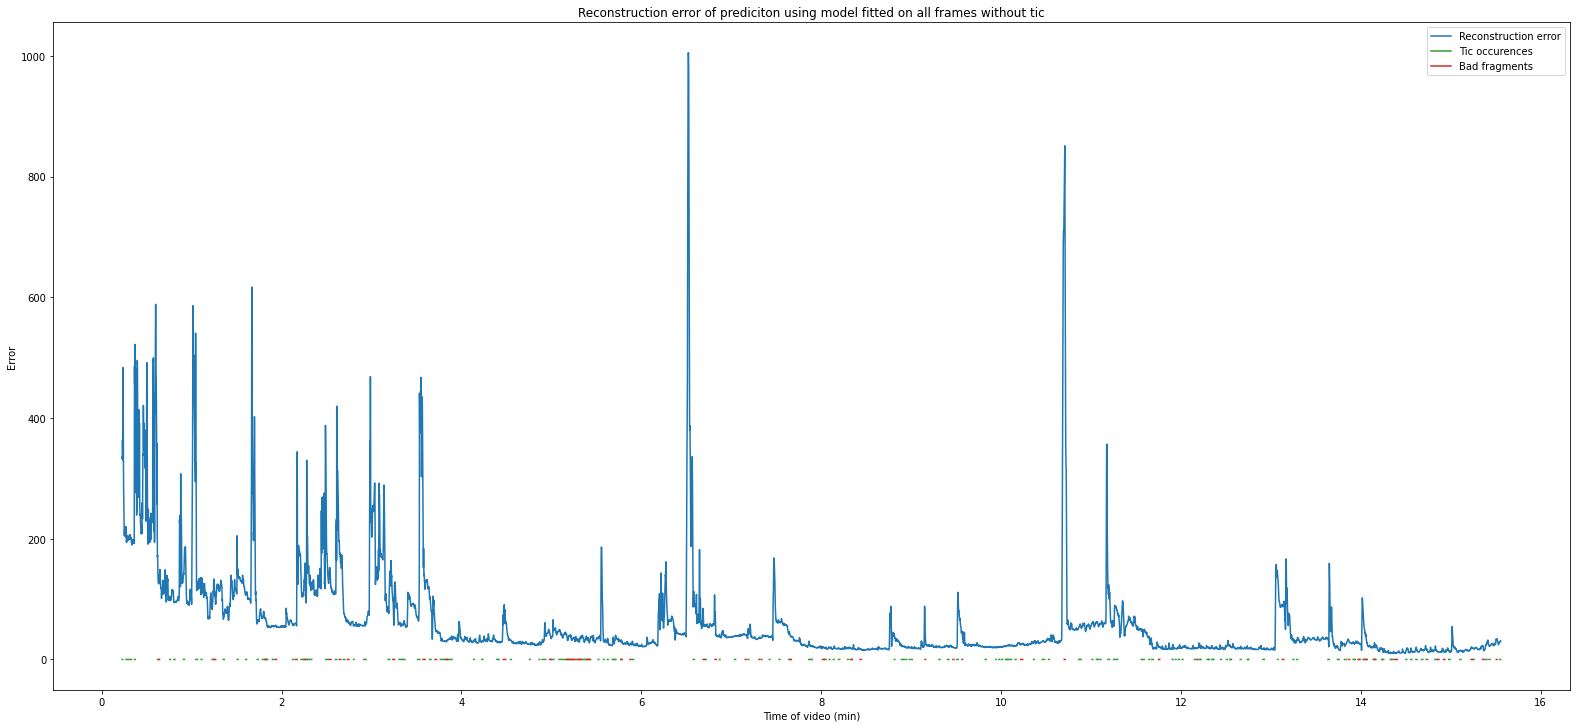

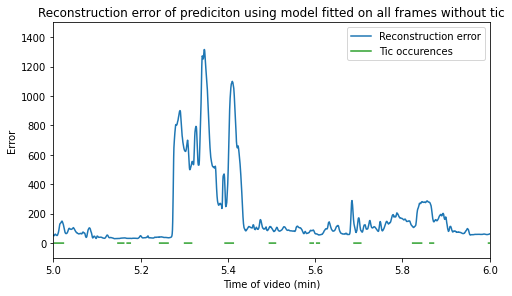

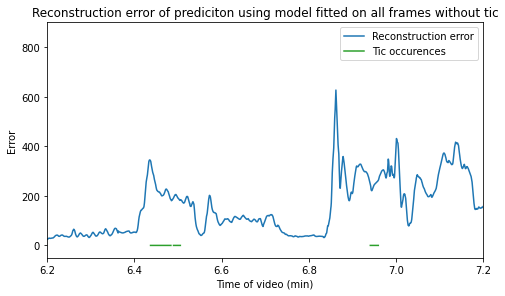

In [10]:
show_bad_label = [True, False, False]
big_fig = [True, False, False]
for i, video_data in enumerate(videos_data):
    if big_fig[i]:
        plt.figure(figsize=(22,10))
    else:
        plt.figure(figsize=(7, 4))
    x = (np.arange(video_data['nframes']) + video_data['start frame'])/(60*video_data['video'].fps)
    plt.plot(x[:-1], video_data['errors_normal_models'], label='Reconstruction error')
    plt.plot(x, video_data['tic_mask'], label='Tic occurences', color='tab:green')
    if show_bad_label[i]:
        plt.plot(x, video_data['bad_mask'], label='Bad fragments', color='tab:red')
    else:
        plt.plot(x, video_data['bad_mask'], color='tab:red')
    plt.xlabel('Time of video (min)')
    plt.ylabel('Error')
    _ = plt.legend()
    plt.tight_layout()
    if i == 1:
        plt.xlim(5, 6)
        plt.ylim(-100, 1500)
        plt.savefig('data_generated/report_figures/tic_detection_pred_error_V2.png')
    if i == 2:
        plt.xlim(6.2, 7.2)
        plt.ylim(-50, 900)
        plt.savefig('data_generated/report_figures/tic_detection_pred_error_V4.png')
    plt.title('Reconstruction error of prediciton using model fitted on all frames without tic')
    plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

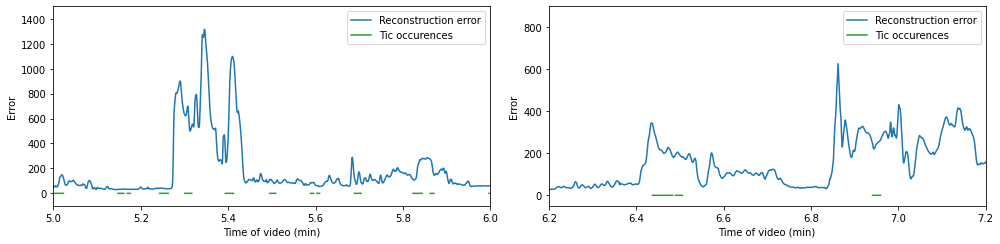

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(14, 3.5))

for i, video_data in enumerate(videos_data[1:]):
    x = (np.arange(video_data['nframes']) + video_data['start frame'])/(60*video_data['video'].fps)
    ax = axs[i]
    ax.plot(x[:-1], video_data['errors_normal_models'], label='Reconstruction error')
    ax.plot(x, video_data['tic_mask'], label='Tic occurences', color='tab:green')
    ax.set_xlabel('Time of video (min)')
    ax.set_ylabel('Error')
    ax.legend()
    if i == 0:
        ax.set_xlim(5, 6)
        ax.set_ylim(-100, 1500)
    if i == 1:
        ax.set_xlim(6.2, 7.2)
        ax.set_ylim(-50, 900)

plt.tight_layout()
plt.savefig('data_generated/report_figures/tic_detection_pred_error_V12.png')
plt.show

### Pre-segmented binary classification

In [9]:
videos_data = pickle.load(open('data_generated/videos_data_tic_detection.pkl', 'rb'))
for i, video_data in enumerate(videos_data):
    filename = video_data['filename']
    fps = video_data['fps']

    fragments_f = video_data['fragments by frame']
    normal_intervals_f = fragments_f[fragments_f[:,2]==0][:,:2]
    tic_intervals_f = fragments_f[fragments_f[:,2]!=0][:,:2]

    video_data['normal_fragments'] = [VideoLoader(filename, start_frame=a, duration_frames=b-a+1, **videos_args) for a, b in normal_intervals_f]
    video_data['tic_fragments'] = [VideoLoader(filename, start_frame=a, duration_frames=b-a+1, **videos_args) for a, b in tic_intervals_f]
    video_data['video'] = VideoLoader(filename, start_frame=video_data['start frame'], duration_frames=video_data['nframes'], **videos_args)

In [9]:
from random import shuffle
ks = np.arange(1, 8)
gammas = np.logspace(-7, -5, base=2, num=10)

def cross_predict(model, gram_matrix, y, nsplits=5, d_transform=None):
    nsample = len(y)
    nsample_per_group = int(nsample/nsplits)
    repeats = [nsample_per_group]*(nsplits-1)
    repeats = repeats + [nsample-np.sum(repeats)]
    groups = np.repeat(np.arange(nsplits), repeats)
    kfolder = GroupKFold(n_splits=nsplits)

    all_preds = []
    all_true = []
    for i, (train_index, test_index) in enumerate(kfolder.split(y, groups=groups)):
        if d_transform is not None:
            gram_train = d_transform(gram_matrix[train_index, :][:, train_index])
            gram_test = d_transform(gram_matrix[test_index, :][:, train_index])
        else:
            gram_train = gram_matrix[train_index, :][:, train_index]
            gram_test = gram_matrix[test_index, :][:, train_index]

        # Predict
        model.fit(gram_train, y[train_index])
        preds = model.predict(gram_test)
        all_preds.append(preds)
        all_true.append(y[test_index])

    return np.concatenate(all_preds), np.concatenate(all_true)

#### V1

In [6]:
video_data = videos_data[0]

all_fragments = video_data['tic_fragments'] + video_data['normal_fragments']
y = np.array([1]*len(video_data['tic_fragments']) + [0]*len(video_data['normal_fragments']))

X = []
discard_fragments = []
for i, fragment in enumerate(all_fragments):
    if fragment.duration_frames < ncomp:
        discard_fragments.append(i)
        continue

    fragment.torch = False
    all_frames = fragment.get_all_frames().reshape(fragment.duration_frames, -1)

    compression_model = custom_pca(ncomp)
    compression_model.fit(all_frames)
    frames_enc, shape = compression_model.encode(all_frames)
    A = np.linalg.pinv(frames_enc[:-1])@frames_enc[1:]

    X.append((compression_model, A))
temp = len(y)
y = np.array([tic for i, tic in enumerate(y) if i not in discard_fragments])
print(f'{temp-len(y)} of {temp} fragments discarded (too short)')

15 of 256 fragments discarded (too short)


In [7]:
full_martin_gram = np.zeros((len(X), len(X)))
for i, mi in enumerate(X):
    for j, mj in enumerate(X):
        if i > j:
            full_martin_gram[i,j] = full_martin_gram[j,i]
        else:
            # Check: negative values appear when computing distance. For the moment round them to zero
            # while verifying they are all small enough
            if martin_dist(mi, mj) < -1e-13:
                raise ValueError('Negative values should not appear.')

            full_martin_gram[i,j] = martin_dist(mi, mj)

In [8]:
pickle.dump(X, open('data_generated/tic_detection_pre-segmented_V1_X.pkl', 'wb'))
pickle.dump(y, open('data_generated/tic_detection_pre-segmented_V1_y.pkl', 'wb'))
pickle.dump(full_martin_gram, open('data_generated/tic_detection_pre-segmented_V1_gram.pkl', 'wb'))

In [10]:
y = pickle.load(open('data_generated/tic_detection_pre-segmented_V1_y.pkl', 'rb'))
full_martin_gram = pickle.load(open('data_generated/tic_detection_pre-segmented_V1_gram.pkl', 'rb'))
full_martin_gram[full_martin_gram < 0] = 0

In [11]:
#shuffle_i = np.random.permutation(len(full_martin_gram))
#X = [X[i] for i in shuffle_i]
#y = y[shuffle_i]

# Evaluation using KNN
confusions_matrices_knn = np.zeros((len(ks), 2, 2))
accuracies_knn = np.zeros(len(ks))
weighted_accuracies_knn = np.zeros(len(ks))
for ki, k in enumerate(ks):
    knn = KNeighborsClassifier(n_neighbors=k, metric='precomputed', n_jobs=2)
    preds, true = cross_predict(knn, full_martin_gram, y)
    accuracies_knn[ki] = accuracy_score(true, preds)
    weighted_accuracies_knn[ki] = balanced_accuracy_score(true, preds)
    confusions_matrices_knn[ki] = confusion_matrix(true, preds, normalize='true')

# Evaluation using SVM
svm_model = SVC()
confusions_matrices_svm = np.zeros((len(gammas), 2, 2))
accuracies_svm = np.zeros(len(gammas))
weighted_accuracies_svm = np.zeros(len(gammas))
for gammai, gamma in enumerate(gammas):
    preds, true = cross_predict(svm_model, full_martin_gram, y, d_transform=lambda x: np.exp(-gamma*x))
    accuracies_svm[ki] = accuracy_score(true, preds)
    weighted_accuracies_svm[ki] = balanced_accuracy_score(true, preds)
    confusions_matrices_svm[ki] = confusion_matrix(true, preds, normalize='true')

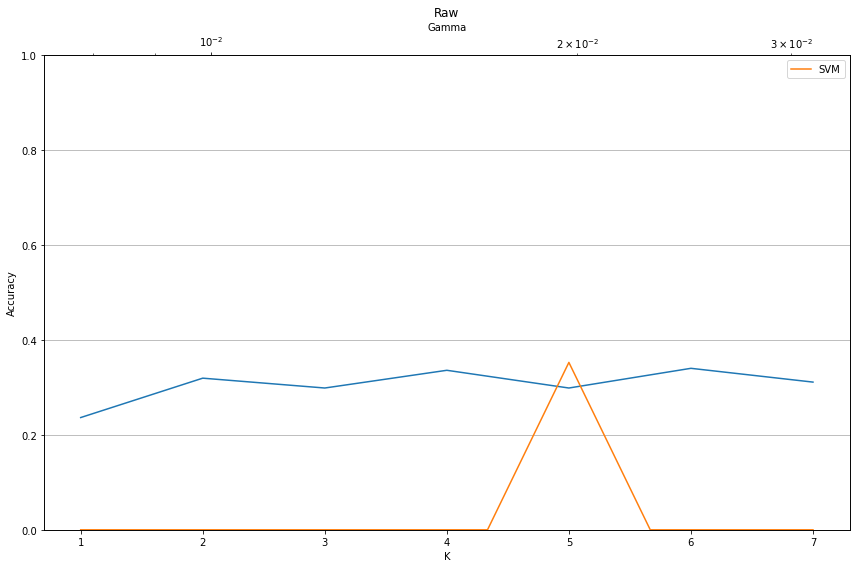

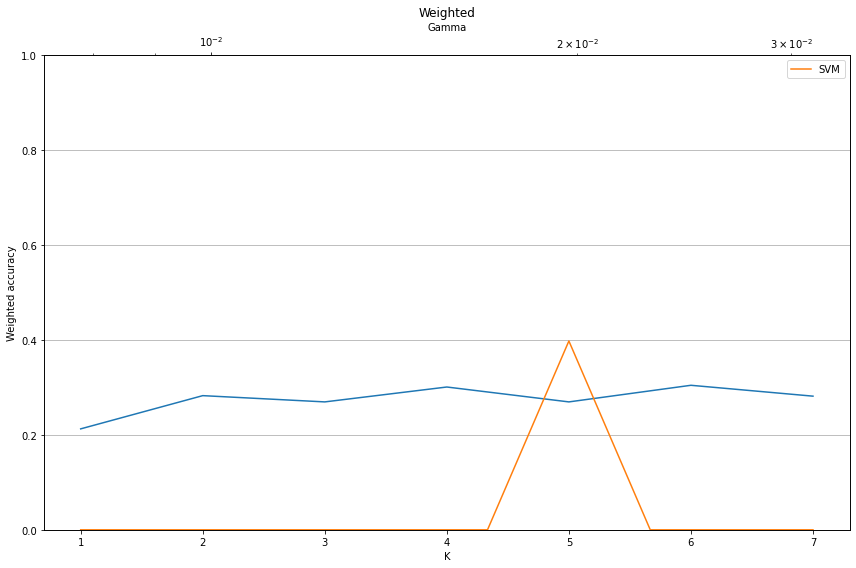

In [12]:
colors_KNN = ['tab:blue', 'tab:cyan']
colors_SVM = ['tab:orange', 'tab:red']
yrange =(0, 1)

# Accuracy
plt.figure(figsize=(12,8))
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.grid(axis='y')
plt.ylim(yrange)
plt.plot(ks, accuracies_knn, label='KNN', color=colors_KNN[0])

ax1 = plt.gca()
ax2 = ax1.twiny()
ax2.set_xlabel('Gamma')
ax2.tick_params(axis='x')
ax2.set_xscale('log')

ax2.plot(gammas, accuracies_svm, label='SVM', color=colors_SVM[0])
#plt.savefig('data_generated/report_figures/evaluation_jigsaws_weighted_accuracy_baseline_%s.png' % i2task[task])
plt.title('Raw')
plt.tight_layout()
plt.legend()
plt.show()

# Weighted accuracy
plt.figure(figsize=(12,8))
plt.xlabel('K')
plt.ylabel('Weighted accuracy')
plt.grid(axis='y')
plt.ylim(yrange)
plt.plot(ks, weighted_accuracies_knn, label='KNN', color=colors_KNN[0])

ax1 = plt.gca()
ax2 = ax1.twiny()
ax2.set_xlabel('Gamma')
ax2.tick_params(axis='x')
ax2.set_xscale('log')

ax2.plot(gammas, weighted_accuracies_svm, label='SVM', color=colors_SVM[0])
#plt.savefig('data_generated/report_figures/evaluation_jigsaws_weighted_accuracy_baseline_%s.png' % i2task[task])
plt.title('Weighted')
plt.tight_layout()
plt.legend()
plt.show()

#### V2

In [12]:
video_data = videos_data[1]

all_fragments = video_data['tic_fragments'] + video_data['normal_fragments']
y = np.array([1]*len(video_data['tic_fragments']) + [0]*len(video_data['normal_fragments']))

X = []
discard_fragments = []
for i, fragment in enumerate(all_fragments):
    if fragment.duration_frames < ncomp:
        discard_fragments.append(i)
        continue

    fragment.torch = False
    all_frames = fragment.get_all_frames().reshape(fragment.duration_frames, -1)

    compression_model = custom_pca(ncomp)
    compression_model.fit(all_frames)
    frames_enc, shape = compression_model.encode(all_frames)
    A = np.linalg.pinv(frames_enc[:-1])@frames_enc[1:]

    X.append((compression_model, A))
temp = len(y)
y = np.array([tic for i, tic in enumerate(y) if i not in discard_fragments])
print(f'{temp-len(y)} of {temp} fragments discarded (too short)')

31 of 457 fragments discarded (too short)


In [13]:
full_martin_gram = np.zeros((len(X), len(X)))
discard_gram = []
for i, mi in enumerate(X):
    for j, mj in enumerate(X):
        if i > j:
            full_martin_gram[i,j] = full_martin_gram[j,i]
        else:
            # Check: negative values appear when computing distance. For the moment round them to zero
            # while verifying they are all small enough
            try:
                if martin_dist(mi, mj) < -1e-13:
                    raise ValueError('Negative values should not appear.')
            except:
                discard_gram.append([i,j])
                continue

            full_martin_gram[i,j] = martin_dist(mi, mj)

In [14]:
pickle.dump(X, open('data_generated/tic_detection_pre-segmented_V2_X.pkl', 'wb'))
pickle.dump(y, open('data_generated/tic_detection_pre-segmented_V2_y.pkl', 'wb'))
pickle.dump(full_martin_gram, open('data_generated/tic_detection_pre-segmented_V2_gram.pkl', 'wb'))
pickle.dump(discard_gram, open('data_generated/tic_detection_pre-segmented_V2_gram_negative_indices.pkl', 'wb'))

In [61]:
X = pickle.load(open('data_generated/tic_detection_pre-segmented_V2_X.pkl', 'rb'))
y = pickle.load(open('data_generated/tic_detection_pre-segmented_V2_y.pkl', 'rb'))
full_martin_gram = pickle.load(open('data_generated/tic_detection_pre-segmented_V2_gram.pkl', 'rb'))
full_martin_gram[full_martin_gram < 0] = 0
discard_gram = pickle.load(open('data_generated/tic_detection_pre-segmented_V2_gram_negative_indices.pkl', 'rb'))

#### V4

In [6]:
video_data = videos_data[2]

all_fragments = video_data['tic_fragments'] + video_data['normal_fragments']
y = np.array([1]*len(video_data['tic_fragments']) + [0]*len(video_data['normal_fragments']))

X = []
discard_fragments = []
for i, fragment in enumerate(all_fragments):
    if fragment.duration_frames < ncomp:
        discard_fragments.append(i)
        continue

    fragment.torch = False
    all_frames = fragment.get_all_frames().reshape(fragment.duration_frames, -1)

    compression_model = custom_pca(ncomp)
    compression_model.fit(all_frames)
    frames_enc, shape = compression_model.encode(all_frames)
    A = np.linalg.pinv(frames_enc[:-1])@frames_enc[1:]

    X.append((compression_model, A))
temp = len(y)
y = np.array([tic for i, tic in enumerate(y) if i not in discard_fragments])
print(f'{temp-len(y)} of {temp} fragments discarded (too short)')

3 of 62 fragments discarded (too short)


In [7]:
full_martin_gram = np.zeros((len(X), len(X)))
discard_gram = []
for i, mi in enumerate(X):
    for j, mj in enumerate(X):
        if i > j:
            full_martin_gram[i,j] = full_martin_gram[j,i]
        else:
            # Check: negative values appear when computing distance. For the moment round them to zero
            # while verifying they are all small enough
            try:
                if martin_dist(mi, mj) < -1e-13:
                    raise ValueError('Negative values should not appear.')
            except:
                discard_gram.append([i,j])
                continue

            full_martin_gram[i,j] = martin_dist(mi, mj)

In [8]:
pickle.dump(X, open('data_generated/tic_detection_pre-segmented_V4_X.pkl', 'wb'))
pickle.dump(y, open('data_generated/tic_detection_pre-segmented_V4_y.pkl', 'wb'))
pickle.dump(full_martin_gram, open('data_generated/tic_detection_pre-segmented_V4_gram.pkl', 'wb'))
pickle.dump(discard_gram, open('data_generated/tic_detection_pre-segmented_V4_gram_negative_indices.pkl', 'wb'))

In [23]:
X = pickle.load(open('data_generated/tic_detection_pre-segmented_V4_X.pkl', 'rb'))
y = pickle.load(open('data_generated/tic_detection_pre-segmented_V4_y.pkl', 'rb'))
full_martin_gram = pickle.load(open('data_generated/tic_detection_pre-segmented_V4_gram.pkl', 'rb'))
full_martin_gram[full_martin_gram < 0] = 0
discard_gram = pickle.load(open('data_generated/tic_detection_pre-segmented_V4_gram_negative_indices.pkl', 'rb'))

In [41]:
shuffle_i = np.random.permutation(len(X))
X = [X[i] for i in shuffle_i]
y = y[shuffle_i]

# Evaluation using KNN
confusions_matrices_knn = np.zeros((len(ks), 2, 2))
accuracies_knn = np.zeros(len(ks))
weighted_accuracies_knn = np.zeros(len(ks))
for ki, k in enumerate(ks):
    knn = KNeighborsClassifier(n_neighbors=k, metric='precomputed', n_jobs=2)
    preds, true = cross_predict(knn, full_martin_gram, y)
    accuracies_knn[ki] = accuracy_score(true, preds)
    weighted_accuracies_knn[ki] = balanced_accuracy_score(true, preds)
    confusions_matrices_knn[ki] = confusion_matrix(true, preds, normalize='true')

# Evaluation using SVM
svm_model = SVC()
confusions_matrices_svm = np.zeros((len(gammas), 2, 2))
accuracies_svm = np.zeros(len(gammas))
weighted_accuracies_svm = np.zeros(len(gammas))
for gammai, gamma in enumerate(gammas):
    preds, true = cross_predict(svm_model, full_martin_gram, y, d_transform=lambda x: np.exp(-gamma*x))
    accuracies_svm[ki] = accuracy_score(true, preds)
    weighted_accuracies_svm[ki] = balanced_accuracy_score(true, preds)
    confusions_matrices_svm[ki] = confusion_matrix(true, preds, normalize='true')

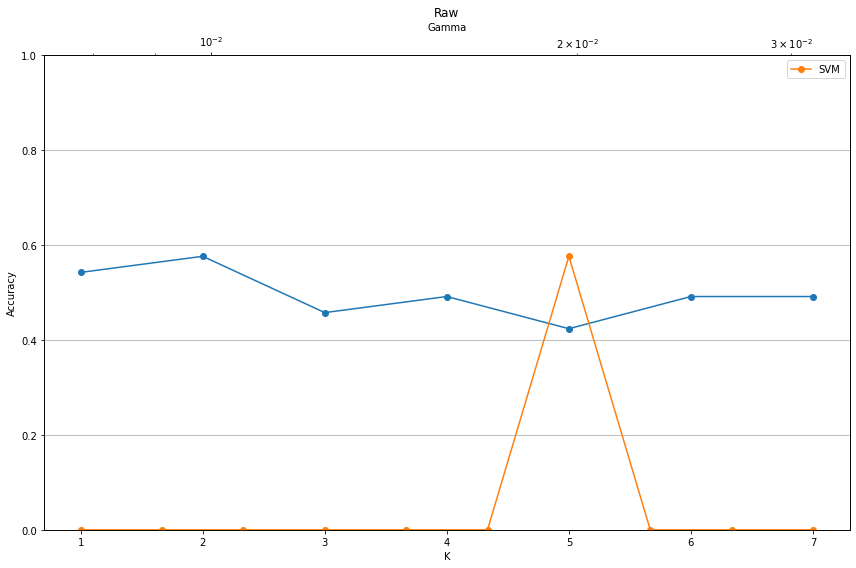

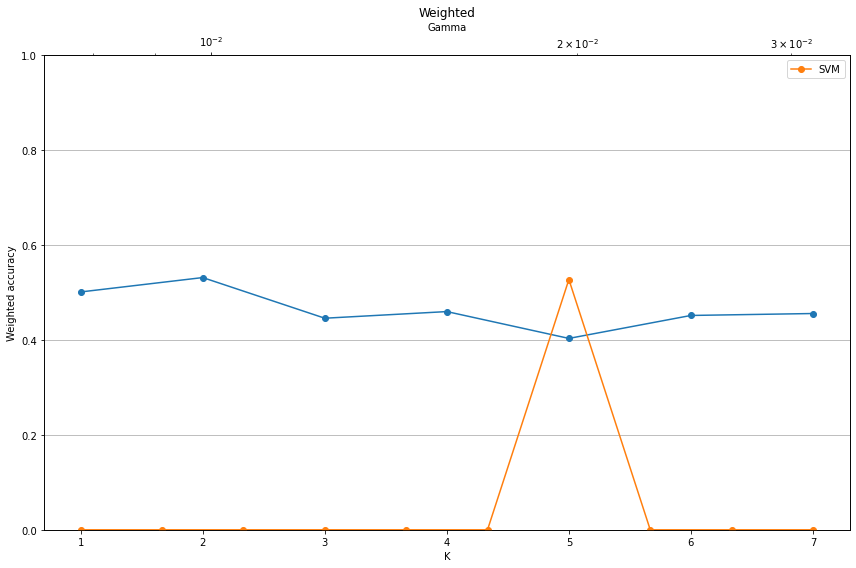

In [42]:
colors_KNN = ['tab:blue', 'tab:cyan']
colors_SVM = ['tab:orange', 'tab:red']
yrange =(0, 1)

# Accuracy
plt.figure(figsize=(12,8))
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.grid(axis='y')
plt.ylim(yrange)
plt.plot(ks, accuracies_knn, label='KNN', color=colors_KNN[0], marker='o')

ax1 = plt.gca()
ax2 = ax1.twiny()
ax2.set_xlabel('Gamma')
ax2.tick_params(axis='x')
ax2.set_xscale('log')

ax2.plot(gammas, accuracies_svm, label='SVM', color=colors_SVM[0], marker='o')
#plt.savefig('data_generated/report_figures/evaluation_jigsaws_weighted_accuracy_baseline_%s.png' % i2task[task])
plt.title('Raw')
plt.tight_layout()
plt.legend()
plt.show()

# Weighted accuracy
plt.figure(figsize=(12,8))
plt.xlabel('K')
plt.ylabel('Weighted accuracy')
plt.grid(axis='y')
plt.ylim(yrange)
plt.plot(ks, weighted_accuracies_knn, label='KNN', color=colors_KNN[0], marker='o')

ax1 = plt.gca()
ax2 = ax1.twiny()
ax2.set_xlabel('Gamma')
ax2.tick_params(axis='x')
ax2.set_xscale('log')

ax2.plot(gammas, weighted_accuracies_svm, label='SVM', color=colors_SVM[0], marker='o')
#plt.savefig('data_generated/report_figures/evaluation_jigsaws_weighted_accuracy_baseline_%s.png' % i2task[task])
plt.title('Weighted')
plt.tight_layout()
plt.legend()
plt.show()

### Misc

In [14]:
videos_data[0].keys()

dict_keys(['filename', 'fps', 'nframes', 'fragments', 'start frame', 'fragments by frame', 'tic_mask', 'normal_pca', 'A_normal', 'errors_normal_models', 'bad_mask', 'normal_fragments', 'tic_fragments', 'video'])

In [18]:
for video_data in videos_data:
    tic_sections = video_data['fragments by frame']
    tic_sections = tic_sections[tic_sections[:,-1]!=0]
    tic_length_sec = (tic_sections[:,1]-tic_sections[:,0]) / video_data['video'].fps
    print(np.mean(tic_length_sec))

0.7726984126984128
0.8121212121212119
1.573076923076923
